# Cluster Number Count prediction using Firecrown

In [60]:
import os
import pyccl as ccl
from typing import Any, Dict
import numpy as np

from firecrown.models.cluster_abundance import ClusterAbundance
from firecrown.models.cluster_mass_rich_proxy import ClusterMassRich, ClusterMassRichBinArgument, ClusterMassRichPointArgument
from firecrown.models.cluster_redshift_spec import ClusterRedshiftSpec, ClusterRedshiftSpecArgument

import matplotlib.pyplot as plt



## Instantiating CCL Cosmology

In [61]:
Omega_c = 0.262
Omega_b = 0.049
Omega_k = 0.0
H0 = 67.66
h = H0 / 100.0
Tcmb0 = 2.7255
A_s = 2.1e-9
sigma8 = 0.8277
n_s = 0.96
Neff = 3.046
w0 = -1.0
wa = 0.0


In [62]:
cosmo_ccl = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=h,
    sigma8=sigma8,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0,
    wa=wa,
    T_CMB=Tcmb0,
    m_nu=[0.00, 0.0, 0.0]
)


## Cluster mass and Cluster redshift objects

To comput the prediction of cluster abundance, we need 5 objets:

1) Cluster Mass object: In this case, `ClusterMassRich`. It has information about how to compute the necessary parameters to build the probability of a mass, given the proxy value. It has the mass-proxy parameters, pivot mass, pivot redshift. It can also be used to generate the point/bin argument, as to generate the bins from a SACC file.

2) Cluster Redshift object: In this case, `ClusterRedshiftSpec`. It has information about how to compute the necessary parameters to build the probability of true redshift, given the proxy value. In this case, we are not using any proxy and assuming the redshift to be the true one. It can also be used to generate the point/bin argument, as to generate the bins from a SACC file.

3) Cluster Abundance object: `ClusterAbundance`. This object must be initialized with a CCL mass function and its respective parameters. It will then be used to compute the number counts prediction.

4) Cluster Mass argument: It can be `ClusterMassRichPointArgument` or `ClusterMassRichBinArgument`. Each one shall be called depending if th user wants to comput the prediction at a bin of mass or only for one point. This type of object can be created from the cluster mass or by explicit declaration.

5) Cluster Redshift argument: In this case, `ClusterRedshiftSpecArgument`. Each one shall be called depending if th user wants to comput the prediction at a bin of mass or only for one point. This type of object can be created from the cluster mass or by explicit declaration.




In [63]:
#Parameters for the ClusterMassRich object. Needed to compute the chi squared variable.
pivot_mass = 14.625862906
pivot_redshift = 0.6

# 1 - `ClusterMassRich`
cluster_mass_r = ClusterMassRich(pivot_mass, pivot_redshift)
#To compute the chi squared variable, we also need the mass-proxy parameters. These parameters are fitted in the analysis if cosmosis is used in firecrown. However, to use only the prediction here, we need to set them.

#Name of the parameters
print(cluster_mass_r.required_parameters().params_names)

#Setting desired random values.
cluster_mass_r.__setattr__("mu_p0", 3.0)
cluster_mass_r.__setattr__("mu_p1", .86)
cluster_mass_r.__setattr__("mu_p2", .0)
cluster_mass_r.__setattr__("sigma_p0", 3.0)
cluster_mass_r.__setattr__("sigma_p1", .7)
cluster_mass_r.__setattr__("sigma_p2", 0.0)


{'mu_p1', 'mu_p0', 'sigma_p0', 'sigma_p2', 'mu_p2', 'sigma_p1'}


In [64]:
# 2 -  `ClusterRedshiftSpec`. In this case, there are no parameters to be set
cluster_z = ClusterRedshiftSpec()
print(cluster_z.required_parameters().params_names)

set()


In [65]:
# 3 - `ClusterAbundance`
hmd_200 = ccl.halos.MassDef200m()
hmf_args: Dict[str, Any] = {}
hmf_name = "Tinker08"
cluster_abundance = ClusterAbundance(hmd_200, hmf_name, hmf_args)

## Point argument

Let us first see the case where we are interesting in cfomputing the prediction for one value of richness and one value of redshift.

In [66]:
#Since we are only interested in one point, we will create the PointArgument object. In the case for the Redshift, we use the same object and set the lower and upper bounds to be the same point.
cluster_mass_point = ClusterMassRichPointArgument(cluster_mass_r, 13,15, 2)
cluster_z_point = ClusterRedshiftSpecArgument(1.0, 1.0)

#Having all the objects, we can compute the prediction in this point

cluster_counts =cluster_abundance.compute(cosmo_ccl, cluster_mass_point, cluster_z_point)

print(f"The number of clusters within the mass range logM = (13,15), with redsfhit z = 1.0 and log\lambda = 2 is {cluster_counts}")

The number of clusters within the mass range logM = (13,15), with redsfhit z = 1.0 and log\lambda = 2 is 1284.574051344072


## Bin argument

In [67]:
#Now we want to compute the prediction of clusters inside bins of richness and redshift, instead of just one point. Therefore we use the BintArgument object. 
cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, 1.0, 2.5)
cluster_z_bin = ClusterRedshiftSpecArgument(0.0, 1.0)

#Having all the objects, we can compute the prediction in this point

cluster_counts_bin =cluster_abundance.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)

print(f"The number of clusters within the mass range logM = (13,15), redsfhit bin z_b = (0.0, 1.0) and log richness bin = (1.0, 2.5) is {cluster_counts_bin}")

The number of clusters within the mass range logM = (13,15), redsfhit bin z_b = (0.0, 1.0) and log richness bin = (1.0, 2.5) is 4075.901554879443


## Plotting for several bins


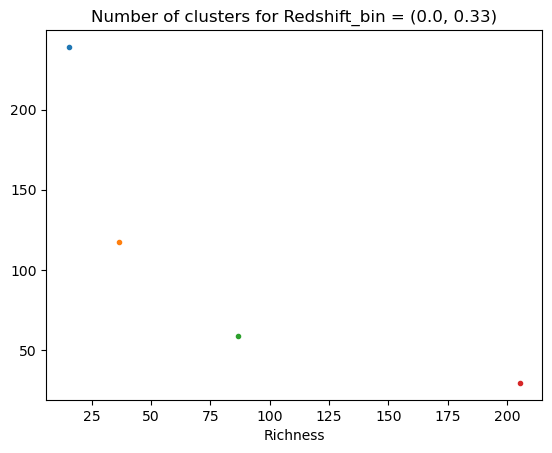

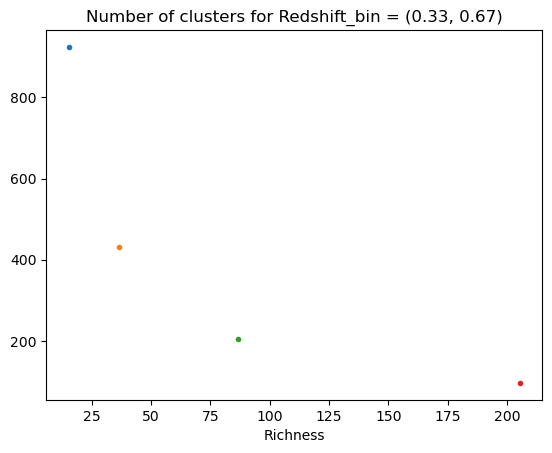

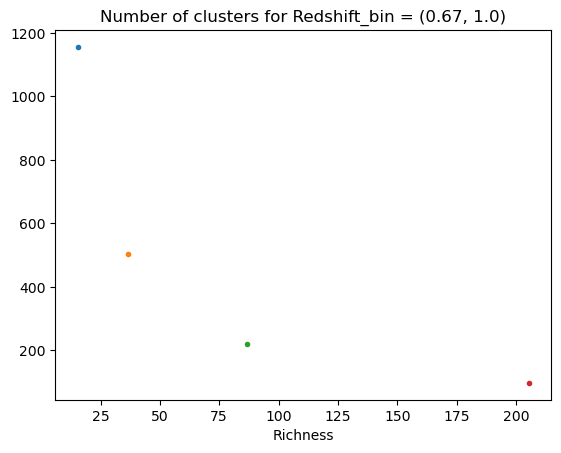

The predictions of clusters in each bin is [239.08028083312462, 117.62461552740133, 58.673712759167984, 29.401592288829168, 924.1733162612882, 431.0462830172569, 203.56022290471452, 96.47939297212574, 1155.6220311710492, 502.3188869523067, 220.7193203429698, 97.20179341249663]


The total number of clusters in the interval is 4075.9014484427303


In [68]:

z_bins = np.linspace(0.0, 1.0, 4)
r_bins = np.linspace(1.0, 2.5, 5)
cluster_counts_list = []
for i in range(0,3):
    for j in range(0,4):
        bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
        cluster_mass_bin = ClusterMassRichBinArgument(cluster_mass_r, 13,15, r_bins[j], r_bins[j+1])
        cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
        cluster_counts =cluster_abundance.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
        cluster_counts_list.append(cluster_counts)
        plt.plot(10**((r_bins[j] + r_bins[j+1])/2), cluster_counts, '.')
    plt.title(f"Number of clusters for Redshift_bin = {(round(z_bins[i],2), round(z_bins[i+1],2))}")
    plt.xlabel("Richness")
    plt.show()
print(f"The predictions of clusters in each bin is {cluster_counts_list}")
print("\n")

print(f"The total number of clusters in the interval is {np.sum(cluster_counts_list)}")


